# **Weather Predictor**
### Multi-Variate Time Series Regression

Sonali Shanbhag 19BDS0114

Anvesh Apkari 19BDS0156

**Mount Google Drive for session storage**

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 1. Import required libraries and packages

In [118]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pylab import rcParams

### Step 2. Read the dataset

In [119]:
dataset = pd.read_csv("/content/daily_weather_2020.csv",parse_dates=["time"])

In [120]:
dataset.head()

,Unnamed: 0,Country/Region,Province/State,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,Lat,Long,precipAccumulation
0,0,Afghanistan,NaN,2019-12-31,Rain (with a chance of 1–3 in. of snow) until ...,rain,1.577847e+09,1.577883e+09,0.20,0.0156,0.1515,1.577902e+09,0.71,rain,48.36,1577864700,32.13,1577922180,47.86,1577864700,29.04,1577921940,23.88,0.60,1019.1,2.56,6.60,1577891880,39,0.99,2,1577864880,5.534,372.6,32.96,1577827140,48.36,1577864700,30.51,1577835720,47.86,1577864700,33.0,65.0,NaN
1,1,Afghanistan,NaN,2020-01-01,Light rain throughout the day.,rain,1.577933e+09,1.577969e+09,0.23,0.0235,0.0985,1.577907e+09,0.95,rain,40.42,1577951460,28.90,1578020400,40.08,1577951220,26.27,1578020400,33.61,0.90,1021.2,2.06,7.08,1577961240,163,0.99,2,1577951280,1.192,330.2,32.33,1577918820,40.42,1577951460,29.84,1577919420,40.08,1577951220,33.0,65.0,NaN
2,2,Afghanistan,NaN,2020-01-02,Clear throughout the day.,rain,1.578019e+09,1.578056e+09,0.26,0.0016,0.0062,1.578010e+09,0.25,rain,46.53,1578038340,28.80,1578106320,46.03,1578038340,26.96,1578093240,29.86,0.76,1022.7,2.45,4.78,1578042840,20,0.22,3,1578037860,9.957,320.3,28.90,1578020400,46.53,1578038340,26.27,1578020400,46.03,1578038340,33.0,65.0,NaN
3,3,Afghanistan,NaN,2020-01-03,Partly cloudy throughout the day.,partly-cloudy-day,1.578106e+09,1.578142e+09,0.30,0.0003,0.0012,1.578158e+09,0.14,rain,45.77,1578124500,32.84,1578193080,45.35,1578124260,33.33,1578193080,26.61,0.69,1021.9,2.95,5.83,1578139740,19,0.32,3,1578122520,10.000,309.6,28.80,1578106320,45.77,1578124500,26.96,1578093240,45.35,1578124260,33.0,65.0,NaN
4,4,Afghanistan,NaN,2020-01-04,Light rain throughout the day.,rain,1.578192e+09,1.578228e+09,0.33,0.0145,0.0310,1.578200e+09,0.83,rain,40.84,1578222000,37.25,1578279840,40.34,1578222000,37.74,1578279840,33.14,0.88,1016.1,1.98,6.14,1578226200,75,1.00,2,1578210360,4.142,308.2,32.84,1578193080,40.84,1578222000,33.33,1578193080,40.34,1578222000,33.0,65.0,NaN


In [121]:
dataset.shape

(30688, 45)

### Step 3. Data Preprocessing

#### i. Check for Missing Values

In [122]:
#finding the columns with missing values
for i in range (44):
  if dataset.isnull().any()[i]==True:
    print(dataset.columns[i])

Province/State
summary
sunriseTime
sunsetTime
precipIntensityMaxTime
precipType


In [123]:
dataset.isnull().sum()

Unnamed: 0                         0
Country/Region                     0
Province/State                 16912
time                               0
summary                            3
icon                               0
sunriseTime                       25
sunsetTime                        25
moonPhase                          0
precipIntensity                    0
precipIntensityMax                 0
precipIntensityMaxTime           104
precipProbability                  0
precipType                      2244
temperatureHigh                    0
temperatureHighTime                0
temperatureLow                     0
temperatureLowTime                 0
apparentTemperatureHigh            0
apparentTemperatureHighTime        0
apparentTemperatureLow             0
apparentTemperatureLowTime         0
dewPoint                           0
humidity                           0
pressure                           0
windSpeed                          0
windGust                           0
w

In [124]:
#dropping columns with more than 50% missing values
dataset=dataset.dropna(thresh=dataset.shape[0]*0.5,how='all',axis=1)

In [125]:
#Columns having less than 1% missing values can simply have their rows ignored
dataset = dataset[dataset['summary'].notna()]
dataset = dataset[dataset['sunriseTime'].notna()]
dataset = dataset[dataset['sunsetTime'].notna()]
dataset = dataset[dataset['precipIntensityMaxTime'].notna()]

In [126]:
#now, only precipType is remaining with approx 7% missing values, so we will use a method of imputation to handle it
#for a categorical column, we will use mode imputation
dataset = dataset.fillna(dataset['precipType'].value_counts().index[0])

In [127]:
dataset.isnull().any()

Unnamed: 0                     False
Country/Region                 False
time                           False
summary                        False
icon                           False
sunriseTime                    False
sunsetTime                     False
moonPhase                      False
precipIntensity                False
precipIntensityMax             False
precipIntensityMaxTime         False
precipProbability              False
precipType                     False
temperatureHigh                False
temperatureHighTime            False
temperatureLow                 False
temperatureLowTime             False
apparentTemperatureHigh        False
apparentTemperatureHighTime    False
apparentTemperatureLow         False
apparentTemperatureLowTime     False
dewPoint                       False
humidity                       False
pressure                       False
windSpeed                      False
windGust                       False
windGustTime                   False
w

In [128]:
#Final Dataset without Missing Values
dataset
dataset.shape

(30558, 43)

#### ii. Cleaning the Columns

In [129]:
#On careful analysis, the dataset has a lot of attributes that we do not require, we will be removing these columns
drop_cols=["Unnamed: 0", "apparentTemperatureMaxTime", "apparentTemperatureMax", "apparentTemperatureMin", "apparentTemperatureMinTime", 
           "temperatureMin", "temperatureMinTime", "temperatureMax", "temperatureMaxTime", "uvIndexTime", "windGust", "windGustTime", 
           "windBearing", "moonPhase", "precipIntensityMax", "precipIntensityMaxTime","temperatureLowTime","apparentTemperatureHighTime",
           "apparentTemperatureLowTime", "dewPoint", "temperatureHighTime","summary", "precipIntensity", "cloudCover",	"uvIndex",
           "visibility",	"ozone","apparentTemperatureHigh","apparentTemperatureLow","Lat","Long"]
dataset.drop(drop_cols, axis='columns', inplace=True)

In [130]:
new_colnames={"Country/Region":"city", 
              "time":"date",
              "icon": "weather",
            }
dataset.rename(columns=new_colnames,inplace=True)

In [131]:
dataset.set_index("date",inplace=True)

In [132]:
dataset= dataset.loc[dataset['city'].isin(['India','Australia','US','Canada','China'])]
dataset=dataset.replace({'city': {'Australia': 'Sydney', 'India': 'New Delhi','Canada':'Toronto','China':'Beijing',"US":'New York'}})

In [133]:
dataset["day"]=dataset.index

#### iii. Converting UNIX timestamp epochs to readable time

In [134]:
dataset['sunriseTime']= pd.to_datetime(dataset['sunriseTime'], unit='s').dt.time

In [135]:
dataset['sunsetTime']= pd.to_datetime(dataset['sunsetTime'], unit='s').dt.time

#### iv. Handling Categorical Variables (Label Encoding)

In [136]:
le=LabelEncoder()

In [137]:
print(dataset.weather.unique())
print(dataset.precipType.unique())

['clear-day' 'partly-cloudy-day' 'rain' 'wind' 'cloudy' 'snow' 'fog']
['rain' 'snow']


In [138]:
dataset['weather']=le.fit_transform(dataset['weather'])
dataset['precipType']=le.fit_transform(dataset['precipType'])

In [139]:
dataset.head()

,city,weather,sunriseTime,sunsetTime,precipProbability,precipType,temperatureHigh,temperatureLow,humidity,pressure,windSpeed,day
date,,,,,,,,,,,,
2019-12-31,Sydney,0,18:53:00,09:24:00,0.11,0,92.24,48.86,0.53,1013.5,3.96,2019-12-31
2020-01-01,Sydney,0,18:54:00,09:24:00,0.04,0,90.40,49.83,0.56,1017.3,3.76,2020-01-01
2020-01-02,Sydney,0,18:54:00,09:24:00,0.00,0,94.53,62.30,0.57,1014.2,3.63,2020-01-02
2020-01-03,Sydney,0,18:55:00,09:24:00,0.09,0,104.66,61.24,0.40,1008.4,6.05,2020-01-03
2020-01-04,Sydney,3,18:56:00,09:24:00,0.11,0,80.83,54.63,0.64,1016.9,5.63,2020-01-04


###Step 4. Splitting into a Time Series Dataframe for each Region

In [140]:
dataset.city.unique()

array(['Sydney', 'Toronto', 'Beijing', 'New Delhi', 'New York'],
      dtype=object)

In [141]:
df_sydney = dataset.loc[dataset['city']=='Sydney']
df_toronto = dataset.loc[dataset['city']=='Toronto']
df_beijing = dataset.loc[dataset['city']=='Beijing']
df_newdelhi = dataset.loc[dataset['city']=='New Delhi']
df_newyork = dataset.loc[dataset['city']=='New York']

### Step 5. Time Series Visualization

##### i. Humidity and Temperature Graphs

In [142]:
#removing duplicate indices for simplicity of graph
df_sydney.drop_duplicates(subset="day",inplace=True)
df_toronto.drop_duplicates(subset="day",inplace=True)
df_beijing.drop_duplicates(subset="day",inplace=True)
df_newyork.drop_duplicates(subset="day",inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [143]:
#function to plot time-series line graphs for each city
def plotfunc(df,city):
  plt.figure(figsize=(18, 5))
  plt.style.use('classic')
  rcParams['xtick.labelsize'] = 8

  plt.subplot(1,2,1)
  plt.xlabel("Date")
  plt.ylabel("Temperature (F)")
  plt.title("Temperatures in "+city)
  plt.plot(df["temperatureHigh"])
  plt.plot(df["temperatureLow"])
  plt.legend(['max', 'min'],loc ="lower right")


  plt.subplot(1,2,2)
  plt.xlabel("Date")
  plt.ylabel("Percent (%)")
  plt.title("Humidity and Precipitation in "+city)
  plt.plot(df["humidity"]*100)
  plt.plot(df["precipProbability"]*100)
  plt.legend(['humidity', 'precipProbability'],loc ="lower right")

  plt.show()

###### New Delhi

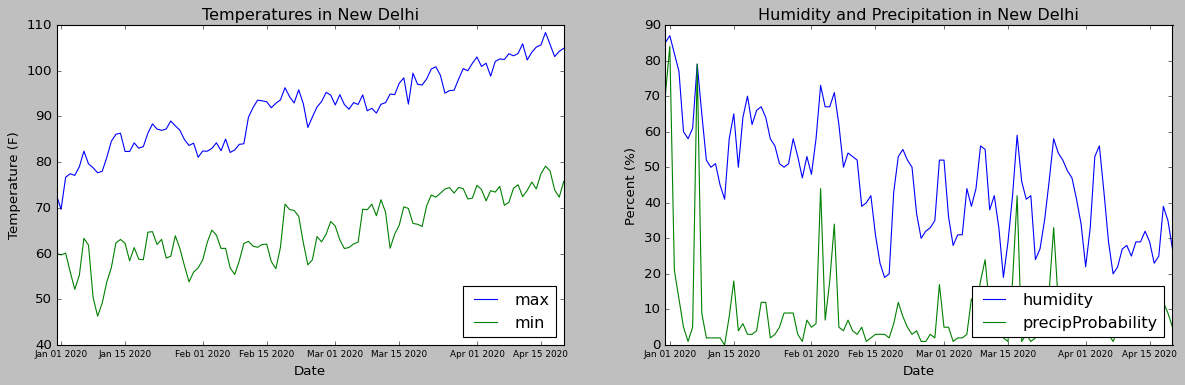

In [144]:
plotfunc(df_newdelhi,"New Delhi")

###### Sydney

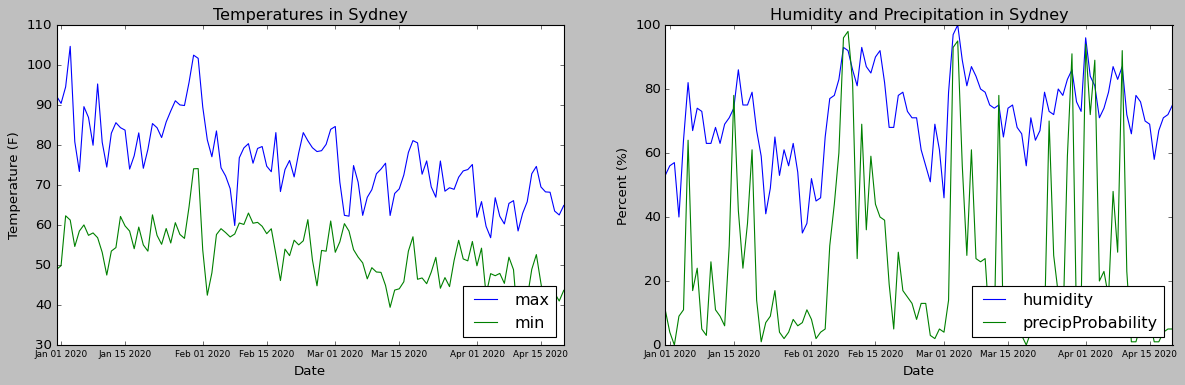

In [145]:
plotfunc(df_sydney,"Sydney")

###### Toronto

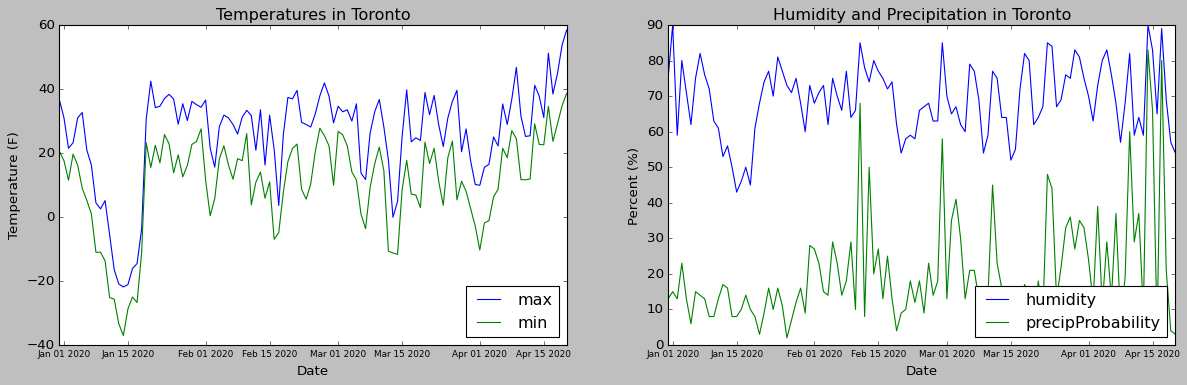

In [146]:
plotfunc(df_toronto,"Toronto")

###### Beijing

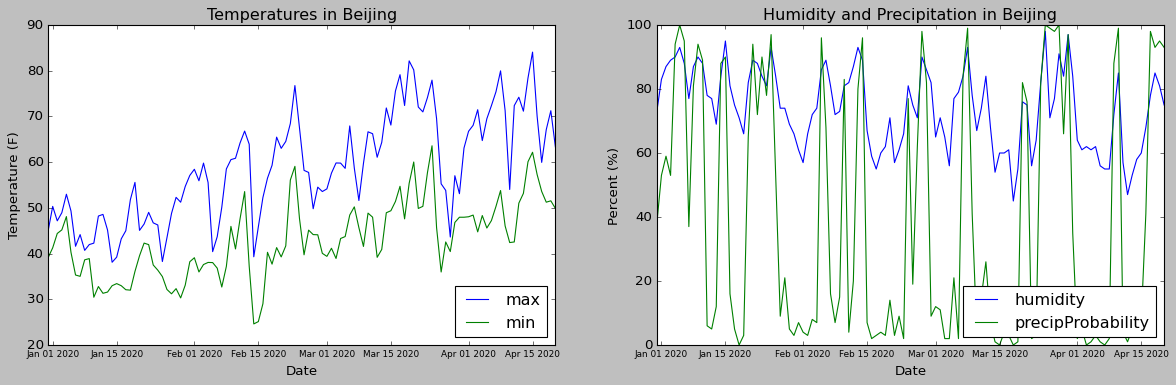

In [147]:
plotfunc(df_beijing,"Beijing")

###### New York

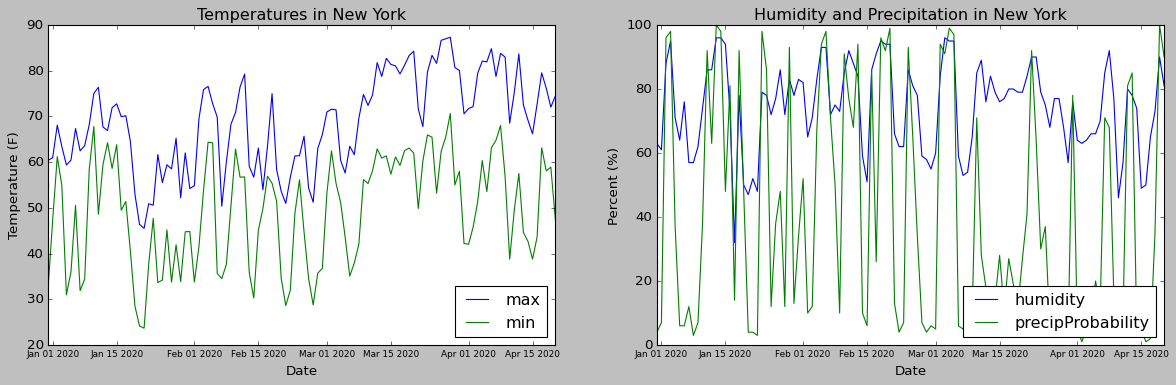

In [148]:
plotfunc(df_newyork,"New York")

##### ii. Comparing Weather Type

In [149]:
#function to plot graphs for weather occurence frequency
icon = {0:'clear',1:'cloudy',2:'fog',3:'partly-cloudy',4:'rain',5:'snow',6:'wind'}
def weatherplot(df,city):
  temp = df.groupby("weather").count()
  count = temp["city"]
  weather = [icon[i] for i in temp.index]
  plt.pie(count, labels=weather,colors=['lightskyblue', 'magenta', 'gold', 'lightgreen', 'aqua','blue','lightpink'])
  plt.title(city+' Weather Conditions in 2020')
  plt.show()
  print("\n")

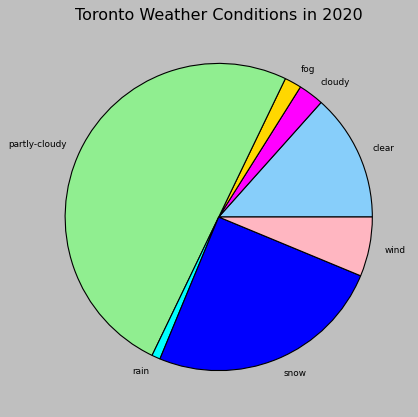

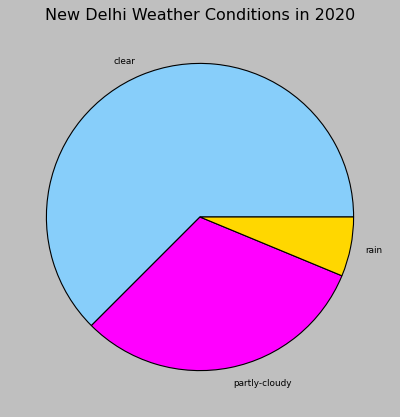

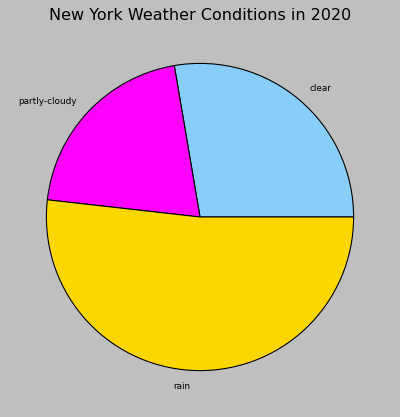

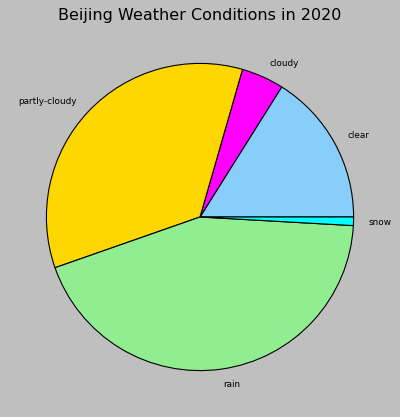

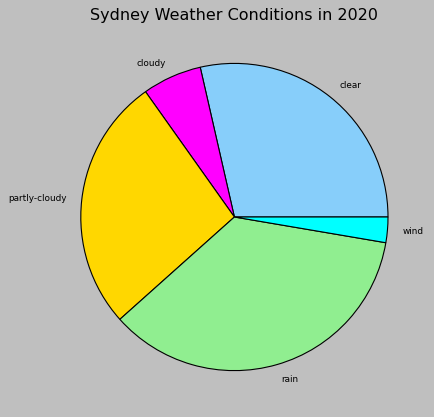

In [150]:
weatherplot(df_toronto,"Toronto")
weatherplot(df_newdelhi,"New Delhi")
weatherplot(df_newyork,"New York")
weatherplot(df_beijing,"Beijing")
weatherplot(df_sydney,"Sydney")

##### iii. Comparing Precipitation Type

In [151]:
#function to plot graphs for weather occurence frequency
ptypes = {0:'rain',1:'snow'}
def precipplot(df,city):
  pr = df.groupby("precipType").count()
  count = pr["city"]
  types = [ptypes[i] for i in pr.index]
  plt.pie(count, labels=types,colors=['lightskyblue', 'white'])
  plt.title(city+' Precipitation in 2020')
  plt.show()
  print("\n")

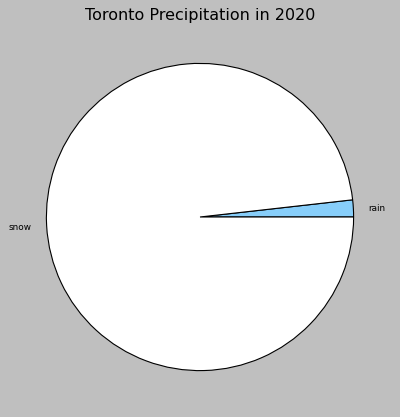

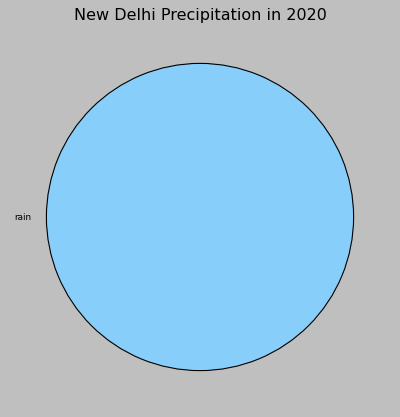

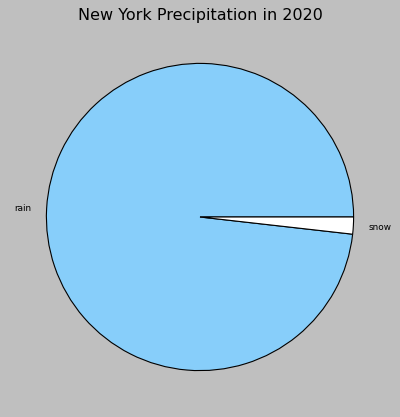

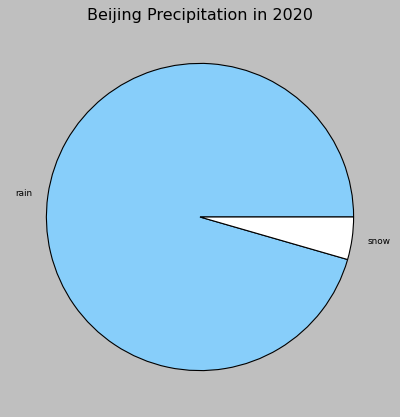

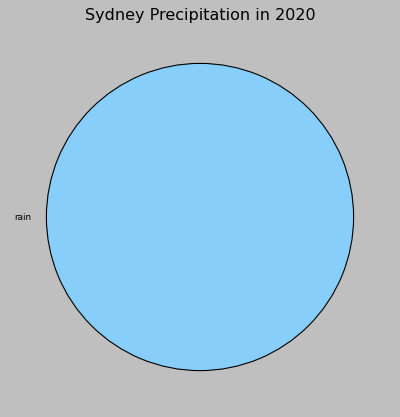

In [152]:
precipplot(df_toronto,"Toronto")
precipplot(df_newdelhi,"New Delhi")
precipplot(df_newyork,"New York")
precipplot(df_beijing,"Beijing")
precipplot(df_sydney,"Sydney")

### Step 6. Download individual city datasets for further modelling (Optional)

In [153]:
df_sydney.to_csv('/content/cities-weather-info/sydney.csv')
df_newdelhi.to_csv('/content/cities-weather-info/newdelhi.csv')
df_newyork.to_csv('/content/cities-weather-info/newyork.csv')
df_beijing.to_csv('/content/cities-weather-info/beijing.csv')
df_toronto.to_csv('/content/cities-weather-info/toronto.csv')

In [154]:
!zip -r /content/cities-weather-info.zip /content/cities-weather-info

updating: content/cities-weather-info/ (stored 0%)
updating: content/cities-weather-info/toronto.csv (deflated 68%)
updating: content/cities-weather-info/sydney.csv (deflated 69%)
updating: content/cities-weather-info/newdelhi.csv (deflated 72%)
updating: content/cities-weather-info/newyork.csv (deflated 70%)
updating: content/cities-weather-info/beijing.csv (deflated 70%)


In [155]:
from google.colab import files
files.download("/content/cities-weather-info.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 7. How to build a VAR Model for one city- a demo

Vector Auto-Regression is a Time Series Prediction Model which analyzes the correlation and interdependence of time series vectors. Here, each column representing a climatic feature is actually a vector. By studying the causality between them, we can get an equation representing each feature as a function of a feature from the previous lag.

In [156]:
dataset = pd.read_csv("/content/cities-weather-info/newyork.csv",parse_dates=["date"],index_col="date")

In [157]:
dataset.head()

,city,weather,sunriseTime,sunsetTime,precipProbability,precipType,temperatureHigh,temperatureLow,humidity,pressure,windSpeed,day
date,,,,,,,,,,,,
2019-12-31,New York,0,12:50:00,22:54:00,0.04,0,60.37,32.53,0.63,1019.4,5.86,2019-12-31
2020-01-01,New York,0,12:50:00,22:54:00,0.07,0,61.00,47.42,0.61,1018.4,2.30,2020-01-01
2020-01-02,New York,4,12:50:00,22:55:00,0.96,0,68.09,61.20,0.88,1011.2,7.90,2020-01-02
2020-01-03,New York,4,12:50:00,22:56:00,0.98,0,63.40,54.90,0.95,1011.4,5.23,2020-01-03
2020-01-04,New York,4,12:51:00,22:57:00,0.37,0,59.38,30.98,0.71,1019.7,9.91,2020-01-04


In [158]:
dataset=dataset[['temperatureLow','temperatureHigh','precipProbability','humidity','pressure','weather']]
dataset.shape

(112, 6)

**Augmented Dickey-Fuller Test**

A test for unit root in univariate process in serial correlation. In simple words, this checks for stationarity in data. Here we consider two hypotheses:

*Null Hypothesis: The data is stationary*

*Alternate Hypothesis: The data is non-stationary*

By checking the p-value we can understand the stationarity. If the p-value is >0.05, apply n-order differencing.

In [159]:
from statsmodels.tsa.stattools import adfuller
#apply first order differencing to get p-value<0.05
for col in dataset.columns:
  ad_fuller_result= adfuller(dataset[col].diff()[1:])
  print(col)
  print(f'ADF Statistic: {ad_fuller_result[0]}')
  print(f'p-value: {ad_fuller_result[1]}')
  print('-----------------------------------')

temperatureLow
ADF Statistic: -7.60431941445599
p-value: 2.344116620029443e-11
-----------------------------------
temperatureHigh
ADF Statistic: -8.375284310008578
p-value: 2.596209030549255e-13
-----------------------------------
precipProbability
ADF Statistic: -5.644738473343843
p-value: 1.0174395482099647e-06
-----------------------------------
humidity
ADF Statistic: -6.129939009862989
p-value: 8.449576325046222e-08
-----------------------------------
pressure
ADF Statistic: -7.67023214887019
p-value: 1.6008849652192747e-11
-----------------------------------
weather
ADF Statistic: -7.271404778852202
p-value: 1.5848858218838962e-10
-----------------------------------


Split into Train and Test Set (80:20 ratio)

In [160]:
train_df=dataset[:-22]
test_df=dataset[-22:]
print(train_df.shape)
print(test_df.shape)

(90, 6)
(22, 6)


Find out the number of lags and select the best order to consider for the time series features in order to maximize the probability of an event. Number of lags is n such that the nth row in the order summary's AIC is minimum (* value)

In [161]:
#find out number of lags to consider
from statsmodels.tsa.api import VAR
model = VAR(train_df.diff()[1:])
sorted_order=model.select_order(maxlags=10)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.745       4.925       115.0       4.817
1        3.351      4.611*       28.61      3.855*
2        3.012       5.352       20.70       3.949
3        3.039       6.458       22.12       4.409
4        3.411       7.910       34.67       5.213
5        3.342       8.920       36.91       5.577
6        3.269       9.928       42.30       5.937
7        3.147       10.89       51.34       6.247
8        2.236       11.05       33.04       5.769
9        1.442       11.34       30.15       5.407
10    -0.4630*       10.51      13.18*       3.935
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Using the VAR Order Selection computed above, fit the model using VARMAX. Use non-stationary data and enforce stationarity.

In [162]:
from statsmodels.tsa.statespace.varmax import VARMAX
var_model=VARMAX(train_df,order=(10,0),enforce_stationarity=True)
fitted_model=var_model.fit(disp=False)
print(fitted_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                                                 Statespace Model Results                                                                
Dep. Variable:     ['temperatureLow', 'temperatureHigh', 'precipProbability', 'humidity', 'pressure', 'weather']   No. Observations:                   90
Model:                                                                                                   VAR(10)   Log Likelihood                -580.970
                                                                                                     + intercept   AIC                           1935.940
Date:                                                                                           Wed, 08 Dec 2021   BIC                           2903.367
Time:                                                                                                   15:42:39   HQIC                          2326.064
Sample:                                                                     

Predict the weather by specifying start date. Here, I have given 20 days post end of test set.

In [163]:
icon = {0:'clear',1:'cloudy',2:'fog',3:'partly-cloudy',4:'rain',5:'snow',6:'wind'}
predict=fitted_model.get_prediction(start=len(test_df)+20)
predictions=predict.predicted_mean
predictions.columns=['temperatureLow','temperatureHigh','precipProbability','humidity','pressure','weather']
predictions=predictions.abs()
predictions['weather']=predictions['weather'].round()
predictions['weather']=[icon[i] for i in predictions.weather]
predictions

,temperatureLow,temperatureHigh,precipProbability,humidity,pressure,weather
2020-02-11,53.059795,77.753767,0.704567,0.918415,1016.922844,rain
2020-02-12,58.556739,79.075960,0.637265,0.866862,1013.755489,rain
2020-02-13,39.657429,61.189361,0.871259,0.835591,1017.431682,rain
2020-02-14,32.009284,57.916571,0.215104,0.629903,1024.340293,cloudy
2020-02-15,38.554075,63.866453,0.115463,0.467437,1029.634631,cloudy
2020-02-16,55.961900,56.912746,0.859218,0.841263,1019.291516,snow
2020-02-17,54.141476,62.280413,0.339468,0.860103,1017.254413,rain
2020-02-18,51.722350,70.591401,1.008213,0.949743,1019.333026,rain
2020-02-19,50.004727,61.834354,0.500691,0.828624,1025.444961,partly-cloudy
2020-02-20,38.401211,55.752482,0.911228,0.909802,1022.826577,rain


In [164]:
import statistics
import math
def avg(arr):
    return sum(arr) / len(arr)

## Basic Model Evaluation

1. Mean Squared Error
2. Mean Absolute Error
3. Root Mean Square Error
4. R-Squared Error

In [165]:
train_df=train_df[42:]

In [166]:
MSE = []
MAE = []
RMSE = []
RSq = []
cols=predictions.columns
cols=cols[:-1]
cols
for col in cols:
  actual=train_df[col].to_numpy()
  pred=predictions[col].to_numpy()
  d = actual-pred
  mse = avg(d*d)
  mae = avg(abs(d))
  rmse = math.sqrt(mse)
  rsq = 1-(sum((d*d)/sum(pow(actual-avg(actual),2))))
  print("Attribute: ", col)
  print("Mean Square Error: ", mse)
  print("Mean Absolute Error: ", mae)
  print("Root Mean Square Error: ", rmse)
  print("R-Squared Error: ", rsq)
  MSE.append(mse)
  MAE.append(mae)
  RMSE.append(rmse)
  RSq.append(rsq)
  print()

Attribute:  temperatureLow
Mean Square Error:  13.28138578948284
Mean Absolute Error:  3.018186088412712
Root Mean Square Error:  3.644363564394041
R-Squared Error:  0.8979093844300904

Attribute:  temperatureHigh
Mean Square Error:  7.390561517693803
Mean Absolute Error:  2.2960983534076136
Root Mean Square Error:  2.718558720663176
R-Squared Error:  0.9365721405871593

Attribute:  precipProbability
Mean Square Error:  0.021820937141620412
Mean Absolute Error:  0.11227421020675127
Root Mean Square Error:  0.1477191156946873
R-Squared Error:  0.8251215471180059

Attribute:  humidity
Mean Square Error:  0.0023413469756769193
Mean Absolute Error:  0.03867305653327321
Root Mean Square Error:  0.04838746713434088
R-Squared Error:  0.8625754462740199

Attribute:  pressure
Mean Square Error:  2.578507255614954
Mean Absolute Error:  1.3154858362562838
Root Mean Square Error:  1.6057731021582577
R-Squared Error:  0.922510133598853



**Visualizing the Errors**

In [167]:
print(MSE)
print(MAE)
print(RMSE)
print(RSq)
print(cols)

[13.28138578948284, 7.390561517693803, 0.021820937141620412, 0.0023413469756769193, 2.578507255614954]
[3.018186088412712, 2.2960983534076136, 0.11227421020675127, 0.03867305653327321, 1.3154858362562838]
[3.644363564394041, 2.718558720663176, 0.1477191156946873, 0.04838746713434088, 1.6057731021582577]
[0.8979093844300904, 0.9365721405871593, 0.8251215471180059, 0.8625754462740199, 0.922510133598853]
Index(['temperatureLow', 'temperatureHigh', 'precipProbability', 'humidity',
       'pressure'],
      dtype='object')


<BarContainer object of 5 artists>

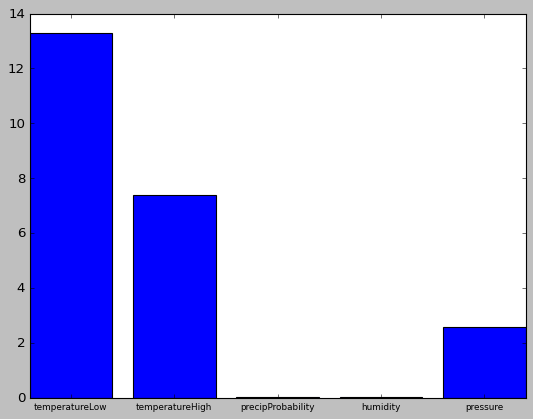

In [168]:
plt.bar(cols, MSE)

<BarContainer object of 5 artists>

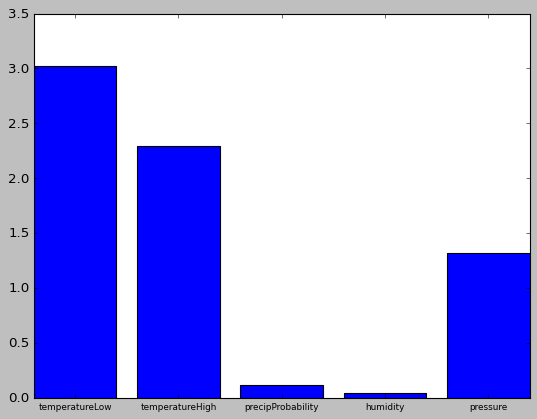

In [169]:
plt.bar(cols, MAE)

<BarContainer object of 5 artists>

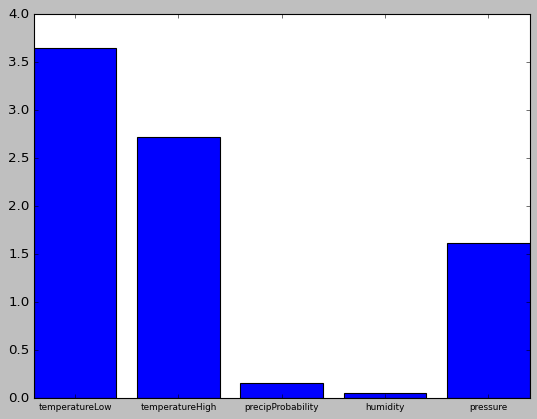

In [170]:
plt.bar(cols, RMSE)

<BarContainer object of 5 artists>

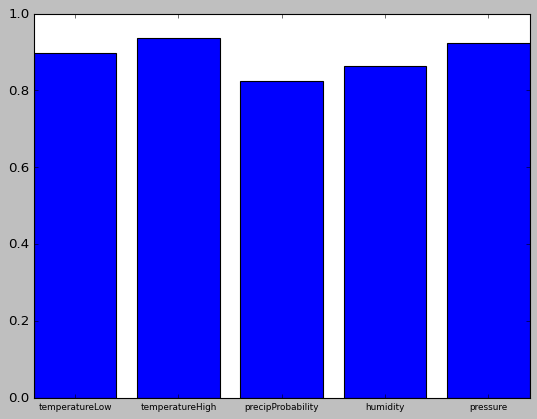

In [171]:
plt.bar(cols, RSq)

## Actual vs Predicted Values Graphs

For the visual analysis of model evaluation, we decided to use R Language, since R is more functional, has more data analysis functionality built-in, a larger ecosystem of small packages and more statistical support in general.

In [172]:
from google.colab import files
train_df.to_csv('train_df.csv') 
predictions.to_csv('predictions.csv') 
files.download('train_df.csv')
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [173]:
icon = {0:'clear',1:'cloudy',2:'fog',3:'partly-cloudy',4:'rain',5:'snow',6:'wind'}
train_df['weather']=[icon[i] for i in train_df.weather]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [174]:
data = train_df["weather"]
pred = predictions["weather"]

In [175]:
acc=0
count=0
for i in range(48):
    count=count+1
    if pred[i]==data[i]:
      acc=acc+1

In [176]:
print("Accuracy of Weather Outlook Prediction: ", (acc/len(data)) * 100, "%")

Accuracy of Weather Outlook Prediction:  54.166666666666664 %
